In [1]:
#import libraries and functions to load the data
from matplotlib import pyplot as plt

import os
import time

import numpy as np
import torch
import torch.nn.functional as F

In [2]:
#for nvidia 
has_gpu = torch.cuda.is_available()
#for mac
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

## Some Hyperparameters 
random_seed = 1
batch_size = 128
learning_rate = 0.01
num_epochs = 10
num_classes = 4

GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


/var/folders/18/jb6sg5tn0wd0md220_4vpttw0000gn/T/ipykernel_32265/3007041442.py:4: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  has_mps = getattr(torch,'has_mps',False)
/var/folders/18/jb6sg5tn0wd0md220_4vpttw0000gn/T/ipykernel_32265/3007041442.py:5: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch,'has_mps',False) \


In [3]:
from torchvision import transforms, datasets
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

train_data_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(32),
        transforms.RandomCrop((28,28)),
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
    ]
)
test_data_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(32),
        transforms.CenterCrop((28,28)),
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
    ]
)

In [4]:
import torchvision.transforms as transforms
from torch.utils.data.dataset import random_split
from torchvision.datasets import FashionMNIST
import torchvision
import torch
from torch.utils.data import DataLoader, Dataset, random_split


dataset = torchvision.datasets.ImageFolder(root='kanji_dataset', transform=train_data_transform)

train_size = int(0.8 * len(dataset))  
test_size = len(dataset) - train_size  
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_size = int(0.9 * len(train_dataset))  
valid_size = len(train_dataset) - train_size  

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])


### Creating DataLoaders to get mini-batches

In [5]:
from torch.utils.data import DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=3,
    shuffle=True
)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=3,
    shuffle=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=3,
    shuffle=False
)

### Visualize the Data

Mini_batch Dimensions: [B, C, H, W] = 
torch.Size([128, 1, 28, 28])


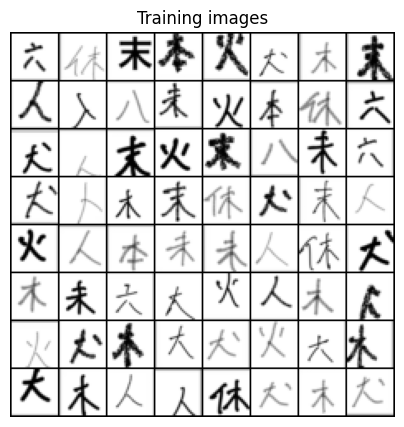

Labels = 
[[ 9 11 10  5  3  6  7 10]
 [ 4  2  1  8  3  5 11  9]
 [ 6  4 10  3 10  1  8  9]
 [ 6  4  7 10 11  6 10  4]
 [ 3  4  5  8  8  4 11  6]
 [ 7  8  9  0  3  4  7  4]
 [ 3  6  7  0  6  3  9  7]
 [ 0  7  4  4 11  6  7  6]]


In [6]:
import torchvision.utils as vutils

%matplotlib inline
import matplotlib.pyplot as plt

im_batch = next(iter(train_loader))
print('Mini_batch Dimensions: [B, C, H, W] = ')
print(im_batch[0].shape)
plt.figure(figsize=(5, 5))
plt.title("Training images")
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(im_batch[0][:64], nrow=8, padding=1, normalize=True), (1, 2, 0)
    )
)
plt.show()
print("Labels = " )
print(im_batch[1][:64].data.numpy().reshape(8,-1))


### Create the Convolutional Neural Network Model

In [7]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        self.cnn_features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )
        self.fc_features = torch.nn.Sequential(
            #torch.nn.AdaptiveAvgPool2d(1),
            torch.nn.Flatten(),
            torch.nn.Linear(3136, 700),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(700, 100),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(100, num_classes)
        )
        
    def forward(self, x):
        x = self.cnn_features(x)
        x = self.fc_features(x)
        return x

### Helper function for Accuracy

In [8]:
def accuracy(model, data_loader, device):
    with torch.no_grad():
        model = model.train()
        true_pred = 0
        tot_samples = 0
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            _, label_pred = torch.max(logits, axis=1)
            true_pred += (label_pred==labels).sum()
            tot_samples += labels.shape[0]
        acc = (true_pred/float(tot_samples))*100
    return acc

### Training Loop

Epoch: 001 Learning Rate 0.01000000 -> 0.01000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch: 001 Learning Rate 0.01000000 -> 0.01000000  Loss: 0.5095  Validation Loss: 0.5198
Train Accuracy: 12.695  Validation Accuracy: 13.008  Time elapsed so far: 0.91 min
Epoch: 002 Learning Rate 0.01000000 -> 0.00500000
Epoch: 002 Learning Rate 0.01000000 -> 0.00500000  Loss: 0.3205  Validation Loss: 0.5473
Train Accuracy: 10.645  Validation Accuracy: 10.569  Time elapsed so far: 1.77 min
Epoch: 003 Learning Rate 0.00500000 -> 0.00500000
Epoch: 003 Learning Rate 0.00500000 -> 0.00500000  Loss: 0.5288  Validation Loss: 0.4719
Train Accuracy: 12.988  Validation Accuracy: 13.008  Time elapsed so far: 2.64 min
Epoch: 004 Learning Rate 0.00500000 -> 0.00250000
Epoch: 004 Learning Rate 0.00500000 -> 0.00250000  Loss: 0.3435  Validation Loss: 0.3941
Train Accuracy: 23.633  Validation Accuracy: 22.764  Time elapsed so far: 3.52 min
Epoch: 005 Learning Rate 0.00250000 -> 0.00250000
Epoch: 005 Learning Rate 0.00250000 -> 0.00250000  Loss: 0.2153  Validation Loss: 0.2520
Train Accuracy: 25.098 

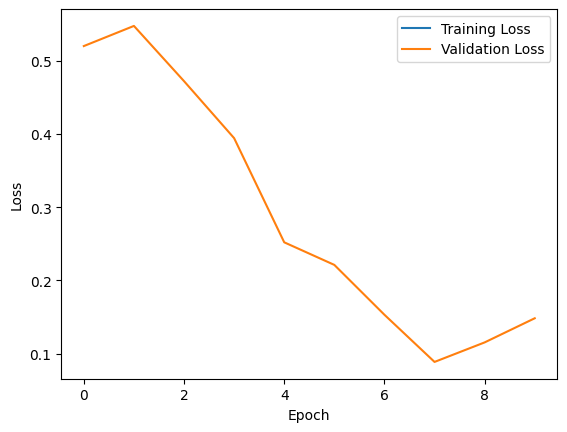

In [10]:
torch.manual_seed(random_seed)
model = CNN(num_classes=num_classes)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
sum_loss = []
train_costs = []  
valid_costs = []  
start = time.time()

for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        ## Forward Propagation - extract features and classify
        logits = model(imgs)
        loss = F.cross_entropy(logits, labels)
        
        #zero out the gradients
        optimizer.zero_grad()
        #estimate new gradients
        loss.backward()
        #update parameters
        optimizer.step()
        
        if not (batch_idx + 1) % 100:
            print(
                f"Epoch: {epoch + 1:03d}/{num_epochs:03d} | "
                f"Batch: {batch_idx + 1:03d}/{len(train_loader):03d} | "
                f"Loss: {loss:.4f}"
            )
            sum_loss.append(loss.item())
    train_costs.append(np.mean(sum_loss))
    sum_loss = []
    # Tracking the Learning Rate Scheduler
    prev_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch: {epoch+1:03d} Learning Rate {prev_lr:.8f} -> {current_lr:.8f}")

    # Evaluate Performance on Validation Set after each epoch
    model = model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for imgs, labels in valid_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            valid_loss += F.cross_entropy(logits, labels, reduction='sum').item()
    valid_loss /= len(valid_loader.dataset)  # 検証損失をバッチごとに正規化
    valid_costs.append(valid_loss)  # 検証損失を記録
    print(f"Epoch: {epoch+1:03d} Learning Rate {prev_lr:.8f} -> {current_lr:.8f}"
            f"  Loss: {loss:.4f}"
            f"  Validation Loss: {valid_loss:.4f}")

    tr_acc = accuracy(model, train_loader, device)
    valid_acc = accuracy(model, valid_loader, device)
    print(f"Train Accuracy: {tr_acc:0.3f}"
    f"  Validation Accuracy: {valid_acc:0.3f}"
    f"  Time elapsed so far: {(time.time() - start) / 60:.2f} min")

print(f"Total Train Time: {(time.time() - start) / 60:.2f} min")

plt.plot(range(len(train_costs)), train_costs, label='Training Loss')
plt.plot(range(len(valid_costs)), valid_costs, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


### Confusion matrix for test data and accuracy

In [11]:
from sklearn.metrics import confusion_matrix

model = model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

ts_acc = accuracy(model, test_loader, device)
print(f"Test Accuracy: {ts_acc:0.3f}")

Confusion Matrix:
[[21  0  3  2  0  0  0  0  0  0  0  0]
 [ 1 30  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 24  0  0  0  0  0  0  0  0  0]
 [ 2  0  0 21  0  0  0  0  0  0  0  0]
 [19  4  7  2  0  0  0  0  0  0  0  0]
 [14  0  8  2  0  0  0  0  0  0  0  0]
 [11  5  0 10  0  0  0  0  0  0  0  0]
 [11  0  6  3  0  0  0  0  0  0  0  0]
 [17  1  0  4  0  0  0  0  0  0  0  0]
 [11  1  0 11  0  0  0  0  0  0  0  0]
 [12  0  8  5  0  0  0  0  0  0  0  0]
 [ 0 23  0  8  0  0  0  0  0  0  0  0]]
Test Accuracy: 30.195
